<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/gensim_train_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
!pip uninstall -y kaggle
!pip install kaggle==1.5.6

# upload kaggle.json to /content
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# go to rules, agree to that --> copy dataset download api from kaggle
!kaggle datasets download -d kazanova/sentiment140
!unzip /content/sentiment140.zip

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=adee8d59e018d352fffd2ec983973302e701ccb3b4d9110b57d0fb467a08cbc5
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
kaggle.json
 34% 5.00M/14.6M [00:00<00:00, 48.0MB/s]
100% 14.6M/14.6M [00:00<00:00, 82.3MB/s]
Archive:  /content/twitter-sentiment-analysis2.zip
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
!pip install gensim --upgrade

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [102]:
import pandas as pd
import numpy as np
train = pd.read_csv("/content/training.1600000.processed.noemoticon.csv" ,header=None, encoding="Latin-1")
# it has 6 rows, 0 and 5 have strings and labels
train.head()
tweets = train[5]
labels = train[0]
print(tweets.shape , labels.shape)


# Remove link,user and special characters\
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
import re
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
tweets = tweets.apply(lambda x: preprocess(x))
tweets.shape

(1600000,) (1600000,)


(1600000,)

In [9]:
documents = [_text.split() for _text in tweets]
len(documents)

1600000

In [10]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300


In [18]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

w2v_model.build_vocab(documents)

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 34517


In [20]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(330406802, 369138528)

In [21]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5615074634552002),
 ('loves', 0.5572818517684937),
 ('loved', 0.528521716594696),
 ('adore', 0.5229439735412598),
 ('amazing', 0.5028786063194275),
 ('miss', 0.4973137080669403),
 ('looove', 0.4919675886631012),
 ('looooove', 0.4613872170448303),
 ('lovee', 0.45974236726760864),
 ('loove', 0.4338608980178833)]

In [32]:
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# here, u will get a sequence for each word in all strings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
text = tokenizer.texts_to_sequences(tweets)
print(text[:3])
print()


#add padding from the starting, so list could be equal in size to 40
maxlentweet = 40
text = pad_sequences(text, maxlen=maxlentweet)
print(text[:3])
print(text.shape)

Using TensorFlow backend.


[[341, 1062, 3365, 11, 719, 9500, 1768, 2], [673, 428, 418, 1901, 192, 414, 2226, 68, 7, 170, 1007], [54856, 210, 249, 1156, 1565, 788, 969, 361, 5, 23197]]

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0   341  1062  3365    11
    719  9500  1768     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   673   428   418  1901   192   414  2226
     68     7   170  1007]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 54856   210   249  1156  1565   788
    969   361     5 23197]]
(1600000, 40)


In [103]:
len(tokenizer.word_index)

335507

In [108]:
w2v_model.wv["word"].shape

(300,)

In [46]:
embedding_matrix = []
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
      embedding_matrix.append(w2v_model.wv[word])
    
embedding_matrix = np.array(embedding_matrix)
print(embedding_matrix.shape)


(34517, 300)


In [ ]:
# labels have 0 and 4 as values, converting them to 0 and 1
import copy
a=[]
labels = copy.deepcopy(train[0])
for i,j in enumerate(labels):
    if j == 4:
        labels[i] = 1
    a=1



In [98]:
from keras import models
from keras import layers
from keras import optimizers



model=models.Sequential()
model.add(layers.Embedding(embedding_matrix.shape[0] , embedding_matrix.shape[1] , input_length=40 , weights=[embedding_matrix]))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(units=80))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           10355100  
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                121920    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 10,477,101
Trainable params: 10,477,101
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
for layer in model.layers:
    print(layer.trainable)
model.layers[0].trainable = False
print()

for layer in model.layers:
    print(layer.trainable)

True
True
True
True

False
True
True
True


In [82]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [83]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [86]:
%%time
history = model.fit(text, labels,
                    batch_size=1024,
                    epochs=1,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1440000 samples, validate on 160000 samples
Epoch 1/1
1440000/1440000 [==============================] - 245s 170us/step - loss: 0.4674 - accuracy: 0.7753 - val_loss: 0.5805 - val_accuracy: 0.7222
CPU times: user 4min 57s, sys: 1min 1s, total: 5min 58s
Wall time: 4min 5s


<Figure size 432x288 with 0 Axes>

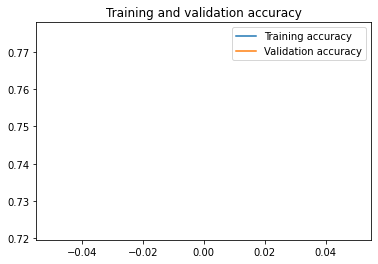

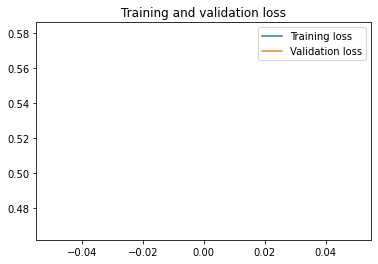

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc , label = 'Training accuracy')
plt.plot( epochs, val_acc, label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs, loss , label = 'Training loss')
plt.plot( epochs, val_loss, label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [91]:
score = model.evaluate(text[:100],labels[:100])
print("ACCURACY:",score[1])
print("LOSS:",score[0])

100/100 [==============================] - 0s 525us/step
ACCURACY: 0.8500000238418579
LOSS: 0.3770274269580841


In [97]:
sent = tokenizer.texts_to_sequences(["you are not a bad boy"])
print(sent)
aa = pad_sequences(sent , maxlen=40)
print(aa)
print(aa.shape)
model.predict(aa)

[[49, 402]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  49 402]]
(1, 40)


array([[0.14167568]], dtype=float32)